In [1]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math, sys, glob, re
import scipy.constants as phco

%matplotlib inline

""" geocentric gravitational constant (m^3/s^2) """
GM = 3.986004418e14
""" Earth radius (m) """
Rearth = 6378000
""" Earth rotation (rad/s) """
wE = 7.292e-5

In [9]:
""" Collecting delays """

def collect_data(dataset_number = 0, carrier_code = "ca", frequency_n = "1"):
    
    current_path = !pwd
    directories = glob.glob(current_path[0] + '/v4.3.2_mb_53896_53907/gs999/*')

    if (dataset_number >= len(directories)):
        print "Dataset does not exist! Change dataset_number. \n"

    """ Extracting the m. Julian day for the dataset"""
    mjd = re.search('%s(.*)%s' % ('mjd','\.'), directories[dataset_number]).group(1)

    path = directories[dataset_number] + '/theo/'
    #path = current_path[0] + '/v4.3.2_mb_53896_53907/gs999/mjd53897.220682_ch1/theo/'
    
    filename = 'v4.3.2_theo_f' + frequency_n + '_' + carrier_code + '.dat'
    data = pd.read_csv(path + filename, delim_whitespace = True, skiprows=1, \
                   names=['time.tag','MJD', 'coord.time', 'prop.time','PToF','geometric.ToF','shapiro','tropo.delay',\
                          'iono.1/f^2', 'iono.1/f^3', 'STEC', 'desynchronisation', 'rangeX', 'rangeY', 'rangeZ', \
                          'sequence.number','Tm'])

    data['distance'] = np.sqrt(data['rangeX']**2 + data['rangeY']**2 + data['rangeZ']**2)

    
    """ Subtracting delays from PToF """
    data['test'] = data['geometric.ToF'] + data['tropo.delay'] + data['iono.1/f^2'] + data['iono.1/f^3'] \
               + data['PToF'] + 1e-3*(-1 if frequency_n=="1" else 1)
    """ This additional +/- 1ms doesn't really matter, because we'll take a derivative"""
      
    return data


#dataset_number = 0
#carrier_code = "ca"      # ["ca", "co"]
#frequency_n = "3"        # ["1", "2", "3"], where "1": GS -> ISS; "2" and "3": ISS -> GS

""" Collecting 2-way data """
data1 = collect_data(dataset_number = 0, carrier_code = "ca", frequency_n = "1")
data2 = collect_data(dataset_number = 0, carrier_code = "ca", frequency_n = "2")

""" Check if these are correct datasets """
assert np.absolute(data1["coord.time"][0] - data2["coord.time"][0]) < 2e-3

""" Collecting ISS positions and velocities """

path = current_path[0] + '/v4.3.2_mb_53896_53907/auxdata/iss/orbit/'
filename = 'v4.3.2_orb_KU_' + mjd
iss_orbit = pd.read_csv(path + filename, delim_whitespace = True, skiprows=1, \
                   names=['julian.day','coord.time', 'x', 'y','z','Vx','Vy','Vz'])


""" Collecting ground station positions and velocities """

path = current_path[0] + '/v4.3.2_mb_53896_53907/auxdata/gs999/orbit/'
filename = 'v4.3.2_orbGS_'  + mjd
gs_orbit = pd.read_csv(path + filename, delim_whitespace = True, skiprows=1, \
                   names=['julian.day','coord.time', 'x', 'y','z','Vx','Vy','Vz'])

def position(dataframe, element=0):
    return np.array([dataframe['x'][element], dataframe['y'][element], dataframe['z'][element]])

def velocity(dataframe, element=0):
    return np.array([dataframe['Vx'][element], dataframe['Vy'][element], dataframe['Vz'][element]])

def unit_vector(vector):
    try:
        normalized = vector/np.linalg.norm(vector)
    except ZeroDivisionError:
        sys.exit("Can't normalize, zero vector!")
    return normalized

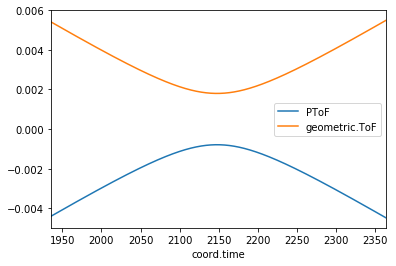

In [12]:
data1.plot(x = 'coord.time', y = ['PToF','geometric.ToF'])

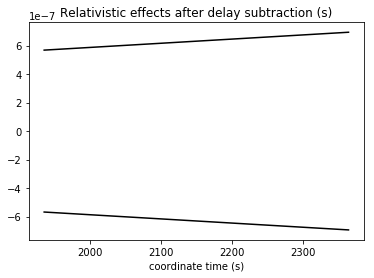

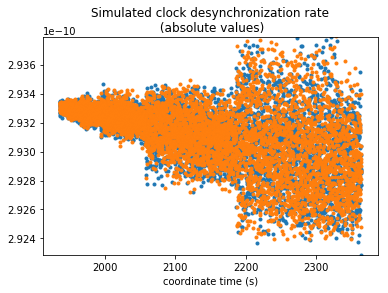

In [28]:
""" Plotting the relativistic effect"""


fig, ax = plt.subplots()
plt.plot(data1['coord.time'], data1['test'], c = 'k')
plt.plot(data2['coord.time'], data2['test'], c = 'k')
plt.xlabel('coordinate time (s)')
plt.title('Relativistic effects after delay subtraction (s)')
plt.show()

""" Taking derivative of that data """

time_steps_experiment = np.gradient(np.array(data1['coord.time']))
data_derivatives1 = np.gradient(np.array(data1['test']))/time_steps_experiment
data_derivatives2 = np.gradient(np.array(data2['test']))/time_steps_experiment

plt.scatter(data1['coord.time'], np.absolute(data_derivatives1), marker = '.')
plt.scatter(data2['coord.time'], np.absolute(data_derivatives2), marker = '.')
plt.ylim(np.min(data_derivatives1), np.max(data_derivatives1))

plt.xlabel('coordinate time (s)')
plt.title('Simulated clock desynchronization rate\n (absolute values)')

In [30]:
""" Forming array of accelerations """

#gs_acceleration = np.array([(velocity(gs_orbit, i+1) - velocity(gs_orbit, i))/(gs_orbit['coord.time'][i] - gs_orbit['coord.time'][i+1]) for i in range(gs_orbit.shape[0]-1)])
#last_element = gs_acceleration[-1] + (gs_orbit['coord.time'].iloc[-1] - gs_orbit['coord.time'].iloc[-2])*(gs_acceleration[-1] - gs_acceleration[-2])/(gs_orbit['coord.time'].iloc[-2] - gs_orbit['coord.time'].iloc[-3])
#gs_acceleration = np.append(gs_acceleration, [last_element], axis=0)

""" Forming array of time steps and preparing it for broadcasting """
time_steps = np.gradient(np.array(gs_orbit['coord.time']))
time_steps_vectorized = np.array([time_steps,]*3).T
gs_velocity = velocity(gs_orbit, np.arange(gs_orbit.shape[0])).T
#np.array([velocity(gs_orbit, i) for i in range(gs_orbit.shape[0])])

""" For 1 sec time step one could drop the time steps, but we'll keep them for compatibility"""

gs_acceleration = np.gradient(gs_velocity, axis = 0)/time_steps_vectorized

assert gs_acceleration.shape[0] == gs_orbit.shape[0]

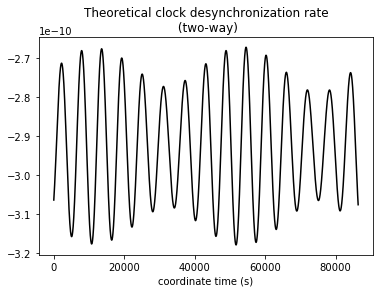

Average calculated desynchronization: -2.9242655874844355e-10
Experimental desynchronization: -2.931069721756393e-10


In [37]:
""" Two-way relativistic effect """

def relativistic_effect(i):
    assert gs_orbit.shape == iss_orbit.shape
    
    r_A = position(iss_orbit, i)
    r_B = position(gs_orbit, i)
    
    abs_r_A = np.linalg.norm(r_A)
    abs_r_B = np.linalg.norm(r_B)
    R_AB = r_B - r_A
    abs_R_AB = np.linalg.norm(R_AB)
    N_AB = R_AB/abs_R_AB
    
    v_A = velocity(iss_orbit, i)
    v_B = velocity(gs_orbit, i)
    abs_v_A = np.linalg.norm(v_A)
    abs_v_B = np.linalg.norm(v_B)
    
    potential_difference = GM*(1/abs_r_B - 1/abs_r_A)/(phco.c**2)
    second_doppler = -.5*(np.linalg.norm(v_B - v_A)/phco.c)**2
    acceleration_term = - np.dot(r_B - r_A, gs_acceleration[i])/(phco.c**2)
    first_doppler = np.dot(N_AB, v_B - v_A)/phco.c
    return (potential_difference + second_doppler + acceleration_term)*(1 + first_doppler)

relativistic_array = [relativistic_effect(i) for i in range(gs_orbit.shape[0])]

fig, ax = plt.subplots()
plt.plot(gs_orbit['coord.time'], relativistic_array, c = 'k')
plt.xlabel('coordinate time (s)')
plt.title('Theoretical clock desynchronization rate\n (two-way)')
plt.show()

# periodicity should be about 5520 s due to the 92 min ISS revolution period

print 'Average calculated desynchronization: ' + str(np.mean(relativistic_array))
print 'Experimental desynchronization: ' + str((data['test'][-1]-data['test'][0])/(data['prop.time'][-1]-data['prop.time'][0]))